In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
#view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_unflattened_wout_true.feather")
#view_1hot_test_df = feather.read_dataframe("/home/whsu014/data/view_1hot_unflattened_test_wout_true.feather")
#view_1hot_df = feather.read_dataframe("/home/whsu014/data/train_24to4.feather")
#view_1hot_test_df = feather.read_dataframe("/home/whsu014/data/test_24to4.feather")

view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)


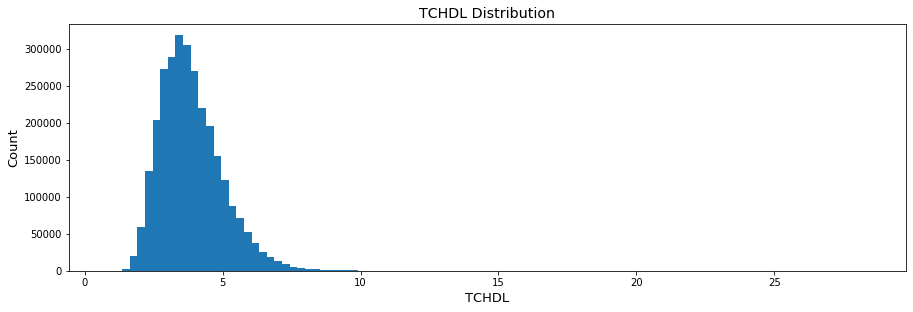

Max: 28.4
Min: 0.8


In [3]:
# Earlier data set will need to
# leave out select PREDICT variables
# 'PT_RUNCVD_MGNT'
# 'PT_ACE_INHIBITOR', 'PT_ASPIRIN', 'PT_AT2', 'PT_BETA_BLOCKER', 
# 'PT_CALCIUM_ANTAGONIST', 'PT_CLOPIDOGREL', 'PT_OTHER_HYP_DRUGS', 
# 'PT_OTHER_LIPID_DRUGS', 'PT_STATIN', 'PT_WARFARIN',
# and True values.
                
pyplot.figure(figsize=(15,10))
pyplot.subplot(211)
fs = 13
pyplot.title('TCHDL Distribution', fontsize=fs*1.1)
pyplot.xlabel('TCHDL', fontsize=fs)
pyplot.ylabel('Count', fontsize=fs)
pyplot.hist(view_1hot_df.TCHDL, bins=100)
#filename = "/home/whsu014/plots/TCHDL_Distribution.png"
#pyplot.savefig(filename)
pyplot.show()

print("Max:", max(view_1hot_df.TCHDL))
print("Min:", min(view_1hot_df.TCHDL))

In [4]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set to length 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0


## Examine Feature Correlation

In [5]:
# Examine feature correlation
# of training data 
print(view_1hot_df.iloc[:(28*90000), :-7].shape)
corr_matrix = view_1hot_df.iloc[:(28*90000), :-7].corr()
print(corr_matrix.shape)

(2520000, 182)
(182, 182)


In [6]:
corr_matrix.iloc[0:5, 0:5]

corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            corr_features.add((corr_matrix.columns[i], 
                               corr_matrix.columns[j]))
for v in corr_features:
    print(v, np.round(corr_matrix.loc[v[0], v[1]], decimals=4))

('out_acs', 'out_mi') 0.8651
('OTHER_PREDNISOLONE', 'OTHER_PREDNISONE') 1.0
('out_acs', 'out_chd') 0.8431
('PT_RENAL', 'PT_DIABETES') 0.8431
('hx_athero_cvd', 'hx_broad_cvd') 0.9575
('TCL', 'LDL') 0.9112
('hx_chd_diags', 'hx_athero_cvd') 0.8478
('hx_other_chd', 'hx_chd_diags') 0.9232
('out_chd', 'out_athero_cvd') 0.8007
('out_other_chd', 'out_angina') 0.9633
('hx_ischaemic_stroke', 'hx_cevd') 0.8174
('out_athero_cvd', 'mortality_broad_cvd_with_other') 0.8561
('out_ischaemic_stroke', 'out_cevd') 0.8283
('hx_chd_diags', 'hx_broad_cvd') 0.8118
('hx_acs', 'hx_chd_diags') 0.8197
('out_broad_cvd', 'mortality_broad_cvd_with_other') 0.9593
('hx_mi', 'hx_acs') 0.882
('out_athero_cvd', 'out_broad_cvd') 0.8924
('OTHER_CLARITHROMYCIN', 'OTHER_AMOXYCILLIN') 1.0


In [7]:
print(corr_matrix.index.get_loc('OTHER_CLARITHROMYCIN'))
print(corr_matrix.columns.get_loc('OTHER_AMOXYCILLIN'))
print(corr_matrix.iloc[115:117, 115:117])

116
115
                      OTHER_AMOXYCILLIN  OTHER_CLARITHROMYCIN
OTHER_AMOXYCILLIN     1.0                1.0                 
OTHER_CLARITHROMYCIN  1.0                1.0                 


## Read in test data

In [8]:
# set up test set
test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds:", len(test_df['VSIMPLE_INDEX_MASTER'].unique()))
test_v = copy.deepcopy(test_df.iloc[:, :-7].values)
print(test_v.shape)
print(test_df.columns.get_loc('TCHDL'))

Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=189)
(282688, 189)
Number of inds: 10096
(282688, 182)
14


## Set up X and y

In [9]:
print('AGE:', view_1hot_df.columns.get_loc('AGE'))
print('NZDEP:', view_1hot_df.columns.get_loc('NZDEP'))
print('ETHN_1:', view_1hot_df.columns.get_loc('ETHN_1'))
print('ETHN_5:', view_1hot_df.columns.get_loc('ETHN_5'))
print('TEST:', view_1hot_df.columns.get_loc('TEST'))
print('HDL:', view_1hot_df.columns.get_loc('HDL'))
print('LDL:', view_1hot_df.columns.get_loc('LDL'))
print('TRI:', view_1hot_df.columns.get_loc('TRI'))
print('TCL:', view_1hot_df.columns.get_loc('TCL'))
print('TCHDL:', view_1hot_df.columns.get_loc('TCHDL'))
print('TESTED:', view_1hot_df.columns.get_loc('TESTED'))
print('DIED:', view_1hot_df.columns.get_loc('DIED'))
print('############# PHARMS ##############')
print('LL_SIMVASTATIN:', view_1hot_df.columns.get_loc('LL_SIMVASTATIN'))
print('LL_PDC:', view_1hot_df.columns.get_loc('LL_PDC'))
print('CVD_FELODIPINE:', view_1hot_df.columns.get_loc('CVD_FELODIPINE'))
print('CVD_HYDROCHLOROTHIAZIDE:', view_1hot_df.columns.get_loc('CVD_HYDROCHLOROTHIAZIDE'))
print('OTHER_TENOXICAM:', view_1hot_df.columns.get_loc('OTHER_TENOXICAM'))
print('OTHER_VILDAGLIPTIN:', view_1hot_df.columns.get_loc('OTHER_VILDAGLIPTIN'))
print('############# NMDS ##############')
print('NUMBER_OF_DAYS:', view_1hot_df.columns.get_loc('NUMBER_OF_DAYS'))
print('hx_broad_cvd:', view_1hot_df.columns.get_loc('hx_broad_cvd'))
print('out_atrial_fibrillation:', view_1hot_df.columns.get_loc('out_atrial_fibrillation'))
print('############# HbA1c, GFR and PT ##############')
print('HBA1C:', view_1hot_df.columns.get_loc('HBA1C'))
print('TEST_HBA1C:', view_1hot_df.columns.get_loc('TEST_HBA1C'))
print('TESTED_HBA1c:', view_1hot_df.columns.get_loc('TESTED_HBA1C'))
print('EGFR:', view_1hot_df.columns.get_loc('EGFR'))
print('TEST_EGFR:',view_1hot_df.columns.get_loc('TEST_EGFR'))
print('TESTED_EGFR:', view_1hot_df.columns.get_loc('TESTED_EGFR'))
print('PT_SBP:', view_1hot_df.columns.get_loc('PT_SBP'))
print('PT_DIABETES_YR:', view_1hot_df.columns.get_loc('PT_DIABETES_YR'))
print('PT_ATRIAL_FIBRILLATION:', view_1hot_df.columns.get_loc('PT_ATRIAL_FIBRILLATION'))
print('PT_IMP_FATAL_CVD:', view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))

AGE: 1
NZDEP: 3
ETHN_1: 4
ETHN_5: 8
TEST: 9
HDL: 10
LDL: 11
TRI: 12
TCL: 13
TCHDL: 14
TESTED: 15
DIED: 16
############# PHARMS ##############
LL_SIMVASTATIN: 17
LL_PDC: 28
CVD_FELODIPINE: 29
CVD_HYDROCHLOROTHIAZIDE: 81
OTHER_TENOXICAM: 82
OTHER_VILDAGLIPTIN: 119
############# NMDS ##############
NUMBER_OF_DAYS: 120
hx_broad_cvd: 122
out_atrial_fibrillation: 162
############# HbA1c, GFR and PT ##############
HBA1C: 163
TEST_HBA1C: 164
TESTED_HBA1c: 165
EGFR: 166
TEST_EGFR: 167
TESTED_EGFR: 168
PT_SBP: 169
PT_DIABETES_YR: 179
PT_ATRIAL_FIBRILLATION: 180
PT_IMP_FATAL_CVD: 181


In [10]:
def set_up_xy_aggregated(time_series):
    num_of_inds = time_series.shape[0]//28
    lmx_v = np.empty((num_of_inds, 
                        (time_series.shape[1])), 
                        dtype='float')
    lmy_v = np.empty((num_of_inds, 1), 
                        dtype='float')
    for i in range(num_of_inds):
        ind_v = copy.deepcopy(time_series[(i*28):((i+1)*28), :])
        for col in range(9):
            lmx_v[i, col] = ind_v[7, col] # id 7
        for col in range(9, 169):
            lmx_v[i, col] = sum(ind_v[:7, col])/7.0 # aggregate using mean for testsafe, phh and nmds
        for col in range(169, 181):
            lmx_v[i, col] = ind_v[7, col]
        lmy_v[i, 0] = ind_v[27, 14]
        #lm_v[i, 183] = ind_v[11, 14] # TCHDL at year 1
        #lm_v[i, 184] = ind_v[15, 14] # TCHDL at year 2
        #lm_v[i, 185] = ind_v[27, 14] # TCHDl at year 5 
    return lmx_v, lmy_v

In [11]:
def set_up_xy(time_series, quarter):
    num_of_inds = time_series.shape[0]//28
    n_features = time_series.shape[1]
    #non sequential
    _x = np.empty((num_of_inds,
                   n_features+(n_features-1)*7), 
                   dtype='float')
    _y = np.empty((num_of_inds, 1), dtype='float') # 3, 
    ###############################################
    # construct x and y  flatten times series 
    # to 1 row.
    ###############################################
    for i in range(num_of_inds):
        ind_v = copy.deepcopy(time_series[(i*28):((i+1)*28), :])
        _x[i, :n_features] = copy.deepcopy(ind_v[0, :])
        for j in range(1, 8):
            start_idx = (j-1)*(n_features-1)+n_features
            end_idx = start_idx + (n_features-1)
            _x[i, start_idx:end_idx] = copy.deepcopy(ind_v[j, 1:])
        _y[i, 0] = ind_v[quarter, 14]
    return _x, _y

In [9]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 
scaled_test = scaler.transform(test_v)
x_train, y_train = set_up_xy(scaled_train, 27)
x_test, y_test = set_up_xy(scaled_test, 27)
print(x_train.shape)
print(y_train.shape)

(90000, 1449)
(90000, 1)


## Search for L2 parameter

In [11]:
# Use efficient Leave one out cross valiation
# also known as Generalized Cross-Validation
start_time = time.time() #3:05
rcv = RidgeCV(alphas=[1e-6, 1e-5, 1e-4, 
                      1e-3, 1e-2, 1e-1,
                      1.0, 10.0], 
             normalize=True,
             store_cv_values=True).fit(x_train, y_train)  
print(time.time() - start_time)

27.42078185081482


In [12]:
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
print(rcv.alpha_)
print(rcv.cv_values_.shape)
print(rcv.score(x_train, y_train))
for i in range(8):
    print("Alpha:", alphas[i])
    print(np.round(np.mean(rcv.cv_values_[:, 0, i]), 
                   decimals=5))

0.1
(90000, 1, 8)
0.42991435151571666
Alpha: 1e-06
1.00728
Alpha: 1e-05
0.94121
Alpha: 0.0001
0.80254
Alpha: 0.001
0.77582
Alpha: 0.01
0.77251
Alpha: 0.1
0.7703
Alpha: 1.0
0.7806
Alpha: 10.0
0.84639


## Comparing Ridge and Linear regression on validation set

In [10]:
num_per_fold = x_train.shape[0]//10
print("Number per fold:", num_per_fold)

start_time = time.time()
end = num_per_fold
train1_x = x_train[:end, ]
train2_x = x_train[end:, ]
train_x_rr = np.append(train2_x, train1_x, axis=0)
val_num = int(np.ceil(train_x_rr.shape[0]/10))
print("val num:", val_num)
train_x = train_x_rr[:-val_num, :]
print("Train x shape:", train_x.shape)

train1_y = y_train[:end, ]
train2_y = y_train[end:, ]
train_y_rr = np.append(train2_y, train1_y, axis=0)
train_y = train_y_rr[:-val_num]
print("Train y shape:", train_y.shape)

rcv = RidgeCV(alphas=[1e-6, 1e-5, 1e-4, 
                      1e-3, 1e-2, 1e-1,
                      1.0, 10.0], 
             #normalize=True,
             store_cv_values=True).fit(train_x, train_y)

val_x = train_x_rr[-val_num:, :]
print("Val x shape:", val_x.shape)
val_y = train_y_rr[-val_num:, :]
print("Val y shape:", val_y.shape)


print("Prediction using RidgeCV")
print("R^2:", rcv.score(train_x, train_y))
val_yhat = rcv.predict(val_x)
print("Mean absolute error:", 
      mean_absolute_error(val_y, val_yhat))
print("Mean squared error:",
      mean_squared_error(val_y, val_yhat))
print("val_yhat shape", val_yhat.shape)
'''
reg = LinearRegression(normalize=True).fit(train_x, train_y)
val_yhat = reg.predict(val_x)
print("Prediction using LinearRegression")
print("R^2:", reg.score(train_x, train_y))
'''
'''
print("Prediction using Ridge")
a = rcv.alpha_
print("Alpha:", a)
rlm = Ridge(alpha=a) #, normalize=True)
rlm = rlm.fit(train_x, train_y)
print("R^2:", rlm.score(train_x, train_y))
val_yhat = rlm.predict(val_x)
print("Mean absolute error:", 
      mean_absolute_error(val_y, val_yhat))
print("Mean squared error:",
      mean_squared_error(val_y, val_yhat))
'''
print(time.time()-start_time)

Number per fold: 9000
val num: 9000
Train x shape: (81000, 1449)
Train y shape: (81000, 1)
Val x shape: (9000, 1449)
Val y shape: (9000, 1)
Prediction using RidgeCV
R^2: 0.435498331482527
Mean absolute error: 0.5231825191899476
Mean squared error: 0.5555844357155749
val_yhat shape (9000, 1)
23.577346324920654


## 20 quarters forecast using 20 regression models

In [12]:
start_time = time.time()

num_per_fold = train_v.shape[0]//280
print("Number per fold:", num_per_fold)

#results_v = np.zeros(((num_per_fold*20), 2)) # store results (validation set)
results_v = np.zeros(((test_v.shape[0]//28*20), 2)) # store results (test set)
#scaler = StandardScaler()
#scaled_train = scaler.fit_transform(train_v) 

for q in range(8, 28):
    x_train, y_train = set_up_xy(train_v, q)
    x_test, y_test = set_up_xy(test_v, q)
    print("Quarter:", q)
    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    
    end = num_per_fold
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_rr = np.append(train2_x, train1_x, axis=0)
    val_num = int(np.ceil(train_x_rr.shape[0]/10))
    print("val num:", val_num)
    train_x = train_x_rr[:-val_num, :]
    print("Train x shape:", train_x.shape)

    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_rr = np.append(train2_y, train1_y, axis=0)
    train_y = train_y_rr[:-val_num]
    print("Train y shape:", train_y.shape)

    rcv = RidgeCV(alphas=[1e-6, 1e-5, 1e-4, 
                          1e-3, 1e-2, 1e-1,
                          1.0, 10.0], 
                 normalize=True,
                 store_cv_values=True).fit(train_x, train_y)

    val_x = train_x_rr[-val_num:, :]
    print("Val x shape:", val_x.shape)
    val_y = train_y_rr[-val_num:, :]
    print("Val y shape:", val_y.shape)


    print("Prediction using RidgeCV")
    print("R^2:", rcv.score(train_x, train_y))
    ########################
    # on validation set
    ########################
    # val_yhat = rcv.predict(val_x)
    # print("Mean absolute error:", 
    # mean_absolute_error(val_y[:, 0], val_yhat[:, 0]))
    # print("Mean squared error:",
    # mean_squared_error(val_y[:, 0], val_yhat[:, 0]))
    ########################
    # on test set
    ########################
    print("Test x shape:", x_test.shape)
    print("Test y shape:", y_test.shape)
    test_yhat = rcv.predict(x_test)
    print("Mean absolute error:", 
    mean_absolute_error(y_test[:, 0], test_yhat[:, 0]))
    ################################
    # store results in np.array
    ################################
    for ind in range(test_v.shape[0]//28):
        results_v[((ind*20)+q-8), 0] = y_test[ind, 0]
        results_v[((ind*20)+q-8), 1] = test_yhat[ind, 0]
print("Mean absolute error:", 
      mean_absolute_error(results_v[:, 0], results_v[:, 1]))
print("Mean squared error:", 
      mean_squared_error(results_v[:, 0], results_v[:, 1]))
#scaled_yhat = copy.deepcopy(scaled_train[:(num_per_fold*28), :])
#yhat = copy.deepcopy(train_v[:(num_per_fold*28), :])

yhat_v = copy.deepcopy(test_v)
for ind in range(yhat_v.shape[0]//28):
    yhat_v[((ind*28)+8):((ind+1)*28), 14] = results_v[(ind*20):((ind+1)*20), 1]
    #scaled_yhat[((ind*28)+8):((ind+1)*28), 14] = \
    #results_v[(ind*20):((ind+1)*20), 1]
    #yhat[((ind*28)+8):((ind+1)*28), 14] = \
    #results_v[(ind*20):((ind+1)*20), 1]
#y = copy.deepcopy(train_v[:(num_per_fold*28), :])

#yhat = scaler.inverse_transform(scaled_yhat)
#y = scaler.inverse_transform(scaled_train[:(num_per_fold*28), :])

print("Yhat shape:", yhat_v.shape)
#print("Y shape:", y.shape)

Number per fold: 9000
Quarter: 8
x_train shape: (90000, 1449)
y_train shape: (90000, 1)
val num: 9000
Train x shape: (81000, 1449)
Train y shape: (81000, 1)
Val x shape: (9000, 1449)
Val y shape: (9000, 1)
Prediction using RidgeCV
R^2: 0.8758774612837615
Test x shape: (10096, 1449)
Test y shape: (10096, 1)
Mean absolute error: 0.15154549324648034
Quarter: 9
x_train shape: (90000, 1449)
y_train shape: (90000, 1)
val num: 9000
Train x shape: (81000, 1449)
Train y shape: (81000, 1)
Val x shape: (9000, 1449)
Val y shape: (9000, 1)
Prediction using RidgeCV
R^2: 0.7771919977334366
Test x shape: (10096, 1449)
Test y shape: (10096, 1)
Mean absolute error: 0.21523516873481763
Quarter: 10
x_train shape: (90000, 1449)
y_train shape: (90000, 1)
val num: 9000
Train x shape: (81000, 1449)
Train y shape: (81000, 1)
Val x shape: (9000, 1449)
Val y shape: (9000, 1)
Prediction using RidgeCV
R^2: 0.7032366699518379
Test x shape: (10096, 1449)
Test y shape: (10096, 1)
Mean absolute error: 0.25526396481827

In [13]:
for i in range(182):
    if not np.array_equal(yhat_v[:, i], test_v[:, i]):
        print(i)

14


In [14]:
yhat_list = []
y_list = []
ind_list = []

for i in range(test_v.shape[0]//28):
    ind_yhat = yhat_v[(i*28):((i+1)*28), :]
    ind_y = test_v[(i*28):((i+1)*28), :]
    if not np.array_equal(ind_yhat[:8, 14], \
                          ind_y[:8, 14]):
        ind_list.append(y[0, 0])
    yhat_list.append(ind_yhat[8:, 14])
    y_list.append(ind_y[8:, 14])
print(len(yhat_list))
print(len(y_list))
print(len(ind_list))
print("Mean absolute error:",
      mean_absolute_error(y_list, yhat_list))
print("Mean squared error:",
      mean_squared_error(y_list, yhat_list))

10096
10096
0
Mean absolute error: 0.3546202864727003
Mean squared error: 0.24830626831377586


In [16]:
yhat_df = pd.DataFrame(yhat_v)
yhat_df.columns = list(test_df.columns)[ :-7]
feather.write_dataframe(yhat_df, "/home/whsu014/data/TCHDL_Ridge_Regression_yhat.feather")